# NEED to run this command in your environment 
# pip install psycopg2-binary

In [9]:
# import the dependencies
import psycopg2
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Scikit-Learn and Shallow Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [6]:
# TF and Keras-related imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# make the connection string to AWS RDS Database
conn_string="host=housingaws-db.cnvxuytbvp1m.us-east-1.rds.amazonaws.com" +" port=5432" +" dbname=housing_database"+" user=postgres"  \
                  +" password=team2data"
#connect to RDS
conn = psycopg2.connect(conn_string)
print("Connected!")    

Connected!


In [8]:
# Read the data from RDS as Pandas 
df=pd.read_sql_query("select * from housing",con=conn)
df.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,Reg,Lvl,AllPub,...,170,0,0,0,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,...,0,0,144,0,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,189000


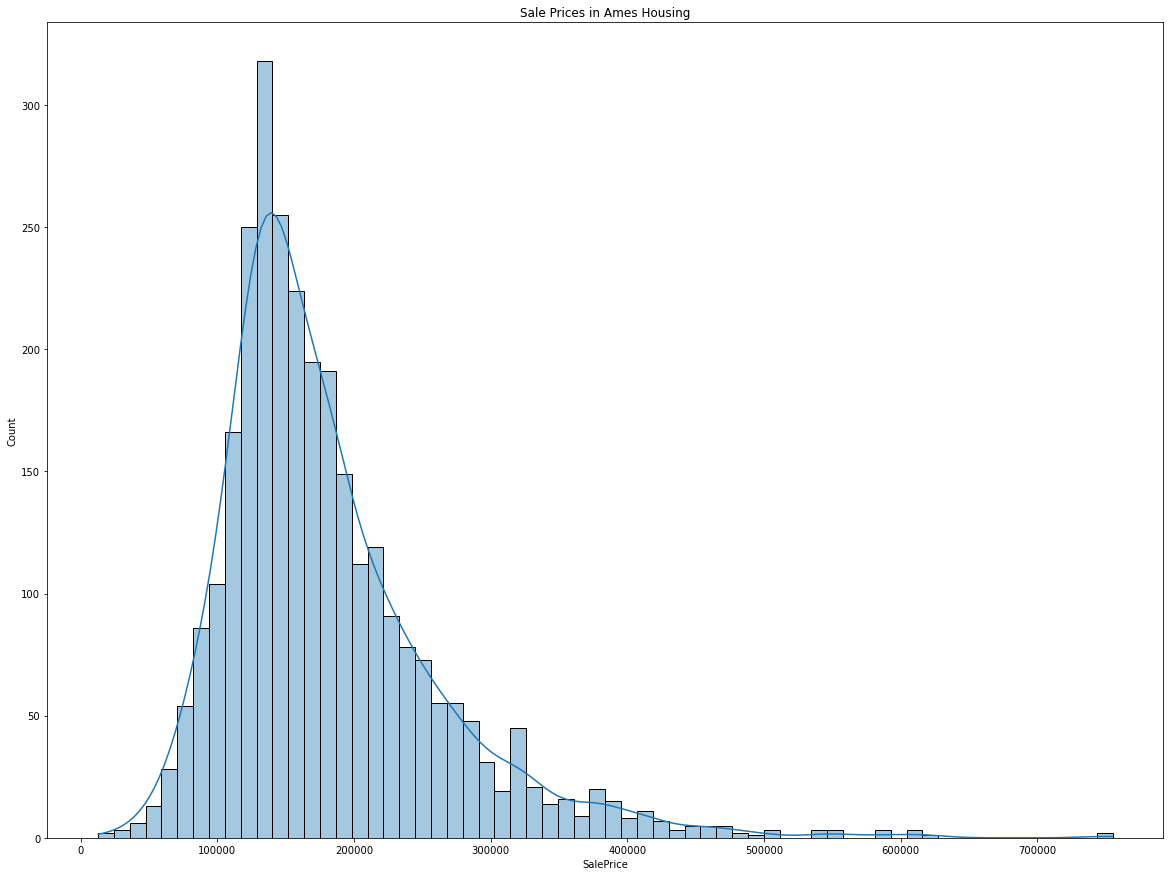

In [19]:
# We can analyze the distribution of the various sales prices on our home dataset 
fig, ax = plt.subplots(figsize=(20,15))
sns.histplot(x=df['SalePrice'], kde=True, ax=ax, alpha=0.4).set(title = "Sale Prices in Ames Housing")
plt.show()

<AxesSubplot:xlabel='SalePrice'>

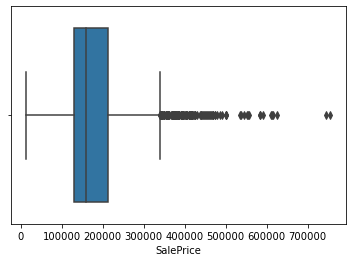

In [20]:
# Boxplot 

sns.boxplot(x=df["SalePrice"])

In [21]:
# Description of the Interquartile ranges 

print(df['SalePrice'].describe())

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


# We could further inspect outliers (this is something to explore over the next deliverable)
# Use heatmap or another way to show correaltion

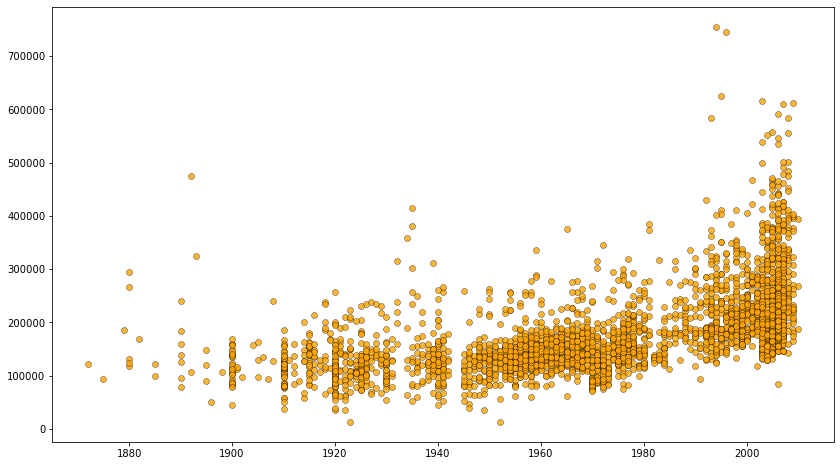

In [22]:
# Examining Correlation amongst features: 

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(
    x=df['Year Built'],
    y=df['SalePrice'],
    color='orange',
    edgecolors='black',
    linewidths=0.4,
    alpha=0.8,
    )

plt.show()

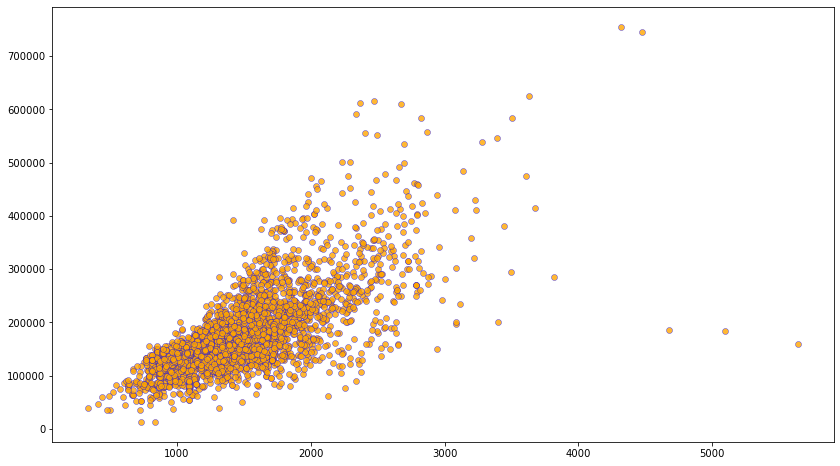

In [23]:
# Living Area vs Sales Price 

fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(
    x=df['Gr Liv Area'],
    y=df['SalePrice'],
    color='orange',
    edgecolors='blue',
    linewidths=0.4,
    alpha=0.8,
    )

plt.show()

In [24]:
# DataPreprocessing:  

# Importance behind Data Preprocessing in our specfic scenario: 
# We might not have houses being sold in a normal condition
# We can have houses that might have had rush sales due to owner requiring money quickly
# We can have data missing for specific features which can skew our results

# Steps to tackle these issues: 
# 1. Identifying Missing Values 
# 2. Decide on what to do with the Missing Values, either remove column/rows or replace with mean value 
# 3. One-Hot Encoding of Categorical Variables ( we will turn our categorical variables in our numerical data type)
# 4. Observing Variable datatypes captured by Pandas, sometimes they provide incorrect data variable type 
# 5. Splitting our data into X_train, X_test, y_train & y_test 
# 6. Standardizing our variable except the target variable 


# exploring data, did you see any trend? 
# what sort of analysis are you doing?

In [25]:
# Identifying the Number of Missing Values 

missing_values = pd.DataFrame({
    'Column': df.columns.values,
    'Number of Missing Value': df.isna().sum().values,
    'Missing Value %': 100 * df.isna().sum().values / len(df),})

missing_values = missing_values[missing_values['Number of Missing Value'] > 0]
print(missing_values.sort_values(by='Number of Missing Value').reset_index(drop=True))

            Column  Number of Missing Value  Missing Value %
0      Bsmt Unf SF                        1         0.034130
1      Garage Area                        1         0.034130
2      Garage Cars                        1         0.034130
3       Electrical                        1         0.034130
4    Total Bsmt SF                        1         0.034130
5      Garage Qual                        1         0.034130
6     BsmtFin SF 2                        1         0.034130
7      Garage Cond                        1         0.034130
8   BsmtFin Type 1                        1         0.034130
9        Bsmt Cond                        1         0.034130
10       Bsmt Qual                        1         0.034130
11    BsmtFin SF 1                        1         0.034130
12  BsmtFin Type 2                        2         0.068259
13  Bsmt Full Bath                        2         0.068259
14  Bsmt Half Bath                        2         0.068259
15   Garage Finish      

In [27]:
# We must decide what we are going to do with all the other variables that have missing values and identify whether the variables are categorical or numerical 

cols_with_missing_values = df.columns[df.isna().sum() > 0]
for col in cols_with_missing_values:

# Print Info 
    
    print(col)
    print(df[col].unique()[:5])

Lot Frontage
[141.  80.  81.  93.  74.]
Mas Vnr Type
['Stone' 'None' 'BrkFace' None 'BrkCmn']
Mas Vnr Area
[112.   0. 108.  20. 603.]
Bsmt Qual
['TA' 'Gd' 'Ex' 'NA' 'Fa']
Bsmt Cond
['Gd' 'TA' 'NA' 'Po' 'Fa']
Bsmt Exposure
['Gd' 'No' 'Mn' 'Av' None]
BsmtFin Type 1
['BLQ' 'Rec' 'ALQ' 'GLQ' 'Unf']
BsmtFin SF 1
[ 639.  468.  923. 1065.  791.]
BsmtFin Type 2
['Unf' 'LwQ' 'BLQ' 'Rec' 'NA']
BsmtFin SF 2
[   0.  144. 1120.  163.  168.]
Bsmt Unf SF
[ 441.  270.  406. 1045.  137.]
Total Bsmt SF
[1080.  882. 1329. 2110.  928.]
Electrical
['SBrkr' 'FuseA' 'FuseF' 'FuseP' None]
Bsmt Full Bath
[ 1.  0.  2.  3. nan]
Bsmt Half Bath
[ 0.  1. nan  2.]
Garage Yr Blt
[1960. 1961. 1958. 1968. 1997.]
Garage Finish
['Fin' 'Unf' 'RFn' 'NA' None]
Garage Cars
[2. 1. 3. 0. 4.]
Garage Area
[528. 730. 312. 522. 482.]
Garage Qual
['TA' 'NA' 'Fa' 'Gd' 'Ex']
Garage Cond
['TA' 'NA' 'Fa' 'Gd' 'Ex']


In [28]:
# Train & Test Split onto the missing values

train_df, test_df = train_test_split(df, test_size=0.2)

In [29]:
# Replacing the values of our numerical values 

num_with_missing = ['Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 
                    'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 
                    'Garage Yr Blt', 'Garage Cars', 'Garage Area']

for n_col in num_with_missing:
    train_df[n_col] = train_df[n_col].fillna(train_df[n_col].mean())
    test_df[n_col] = test_df[n_col].fillna(test_df[n_col].mean())

In [30]:
# Replacing the values of our categorical values

cat_with_missing = [x for x in cols_with_missing_values if x not in num_with_missing]

for c_col in cat_with_missing:
    train_df[c_col] = train_df[c_col].fillna(train_df[c_col].mode().to_numpy()[0])
    test_df[c_col] = test_df[c_col].fillna(test_df[c_col].mode().to_numpy()[0])
    
    
# Our dataset should not have any more missing variables at this point, we can run a code to double check if this is true


In [31]:
df.isna().sum()

# ERROR spotted on LOT FRONTAGE Feature (figure out why this error is arising)

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      490
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 78, dtype: int64

In [32]:
# Checking our Variables Data Types & Confirm whether Pandas is reading any of these variables incorrectly 
data_types = pd.DataFrame({
    'Column': train_df.select_dtypes(exclude='object').columns.values,
    'Data type': train_df.select_dtypes(exclude='object').dtypes.values})

print(data_types)

             Column Data type
0             Order     int64
1               PID     int64
2       MS SubClass     int64
3      Lot Frontage   float64
4          Lot Area     int64
5      Overall Qual     int64
6      Overall Cond     int64
7        Year Built     int64
8    Year Remod/Add     int64
9      Mas Vnr Area   float64
10     BsmtFin SF 1   float64
11     BsmtFin SF 2   float64
12      Bsmt Unf SF   float64
13    Total Bsmt SF   float64
14       1st Flr SF     int64
15       2nd Flr SF     int64
16  Low Qual Fin SF     int64
17      Gr Liv Area     int64
18   Bsmt Full Bath   float64
19   Bsmt Half Bath   float64
20        Full Bath     int64
21        Half Bath     int64
22    Bedroom AbvGr     int64
23    Kitchen AbvGr     int64
24    TotRms AbvGrd     int64
25       Fireplaces     int64
26    Garage Yr Blt   float64
27      Garage Cars   float64
28      Garage Area   float64
29     Wood Deck SF     int64
30    Open Porch SF     int64
31   Enclosed Porch     int64
32       3

In [33]:
# Perform One Hot Encoding 

accepted_vars = ['MS SubClass', 'Lot Frontage', 'Lot Area',
                 'Overall Qual', 'Overall Cond',
                 'Year Built', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
                 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 
                 'Kitchen AbvGr', 'TotRms AbvGrd', 'Garage Area', 
                 'Pool Area']

train_df = train_df[accepted_vars]
test_df = test_df[accepted_vars] 

In [34]:
train_df = pd.get_dummies(train_df).reset_index(drop=True)
test_df = pd.get_dummies(test_df).reset_index(drop=True)
